In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/traffic2'
!ls

/content/drive/MyDrive/traffic2
 800px-STOP_sign.jpg
'download (1).png'
 highway-and-sign-with-speed-limit-120-kmh-.jpg
 Italian_traffic_signs_-_fermarsi_e_dare_precedenza_-_stop.svg.png
 meta
 Meta
 Meta.csv
 model1.dat
 modelhistory1.dat
 modelhistory.dat
 modell1.dat
 modell.dat
 road-sign-warning-bumpy-traffic-board-illustrating-ahead-124353011.jpg
 test
 Test
 Test.csv
 train
 Train
 Train.csv
 xtrainn.dat
 xvall.dat
 ytrainn.dat
 yvall.dat


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os
import matplotlib
import pickle


In [4]:
with open('xtrainn.dat', 'rb') as f:
  xtrain = pickle.load(f)
  print(xtrain.shape)
with open('ytrainn.dat', 'rb') as f:
  ytrain = pickle.load(f)
  print(ytrain.shape)
with open('xvall.dat', 'rb') as f:
  xval = pickle.load(f)
  print(xval.shape)
with open('yvall.dat', 'rb') as f:
  yval = pickle.load(f)  
  print(yval.shape)

(39209, 32, 32, 3)
(39209,)
(12630, 32, 32, 3)
(12630,)


In [5]:
xtrain =np.dot(xtrain[...,:3], [0.299, 0.587, 0.114])
xval = np.dot(xval[...,:3], [0.299, 0.587, 0.114])
xtrain = np.expand_dims(xtrain, axis=3)
xval = np.expand_dims(xval, axis=3)
# one-hot encode the training and testing labels
num_label = len(np.unique(ytrain))
trainY = to_categorical(ytrain, num_label)
testY = to_categorical(yval, num_label)
print(num_label)

# calculate the total number of images in each class and
# initialize a dictionary to store the class weights
classTotals = trainY.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]
print(classWeight)	

43
{0: 10.714286, 1: 1.0135136, 2: 1.0, 3: 1.5957447, 4: 1.1363636, 5: 1.2096775, 6: 5.357143, 7: 1.5625, 8: 1.5957447, 9: 1.5306122, 10: 1.119403, 11: 1.7045455, 12: 1.0714285, 13: 1.0416666, 14: 2.8846154, 15: 3.5714285, 16: 5.357143, 17: 2.0270271, 18: 1.875, 19: 10.714286, 20: 6.25, 21: 6.818182, 22: 5.769231, 23: 4.4117646, 24: 8.333333, 25: 1.5, 26: 3.75, 27: 9.375, 28: 4.1666665, 29: 8.333333, 30: 5.0, 31: 2.8846154, 32: 9.375, 33: 3.2656024, 34: 5.357143, 35: 1.875, 36: 5.769231, 37: 10.714286, 38: 1.0869565, 39: 7.5, 40: 6.25, 41: 9.375, 42: 9.375}


In [95]:
from sklearn.utils import shuffle
x_train_shuffled,y_train_shuffled = shuffle(xtrain, ytrain, random_state=0)
x_val_shuffled,y_val_shuffled = shuffle(xval, yval, random_state=1)
print(x_train_shuffled.shape)
print(x_val_shuffled.shape)

(39209, 32, 32, 1)
(12630, 32, 32, 1)


In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32,1), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2),strides=2),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dropout(0.3),
    # The second convolutional layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D((2,2),strides =2),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dropout(0.3),
    #the third convolutional layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D((2,2), padding='same'),
    tf.keras.layers.BatchNormalization(axis=-1),
    #  neuron hidden layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(num_label, activation='softmax')
])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_28 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_21 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 256)       73984     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 8, 8, 256)       

In [96]:
NUM_EPOCHS = 20
INIT_LR = 1e-3
BS = 64

trainaug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

valaug = ImageDataGenerator()

train_generator = trainaug.flow(x_train_shuffled,y_train_shuffled ,batch_size= BS )
val_generator = valaug.flow(x_val_shuffled,y_val_shuffled )
# initialize the optimizer and compile the model

model2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy'])



In [ ]:
History2 = model2.fit(
    train_generator,
	validation_data=val_generator,
	steps_per_epoch= int(xtrain.shape[0] / BS),
	epochs=NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


612/612 [==============================] - 416s 678ms/step - loss: 3.6588 - accuracy: 0.5793 - val_loss: 1.0448 - val_accuracy: 0.7333
Epoch 2/20
612/612 [==============================] - 405s 661ms/step - loss: 1.2104 - accuracy: 0.8322 - val_loss: 0.5359 - val_accuracy: 0.8852
Epoch 3/20
612/612 [==============================] - 411s 672ms/step - loss: 0.8606 - accuracy: 0.8801 - val_loss: 0.2421 - val_accuracy: 0.9337
Epoch 4/20
612/612 [==============================] - 408s 667ms/step - loss: 0.7012 - accuracy: 0.9071 - val_loss: 0.2261 - val_accuracy: 0.9419
Epoch 5/20
612/612 [==============================] - 404s 660ms/step - loss: 0.5852 - accuracy: 0.9197 - val_loss: 0.4931 - val_accuracy: 0.8972
Epoch 6/20
612/612 [==============================] - 405s 662ms/step - loss: 0.5242 - accuracy: 0.9294 - val_loss: 0.2720 - val_accuracy: 0.9428
Epoch 7/20
612/612 [==============================] - 405s 663ms/step - loss: 0.4629 - accuracy: 0.9372 - val_loss: 0.2000 - val_accura

In [ ]:
pickle.dump(History2, open("modelhistory1.dat", "wb"))
pickle.dump(model2 , open("modell1.dat" , "wb"))

In [ ]:
model2.save("/content/drive/MyDrive")

In [98]:
with open('modell1.dat', 'rb') as f:
  model2 = pickle.load(f)
with open('modelhistory1.dat', 'rb') as f:
  History2 = pickle.load(f)

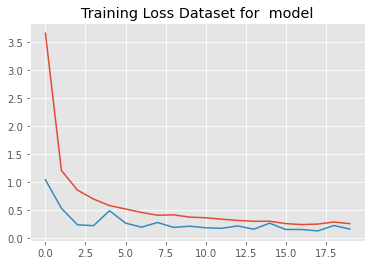

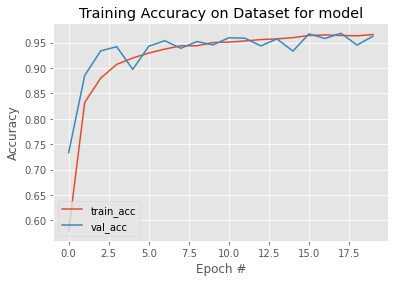

In [103]:
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(1)
plt.title("Training Loss Dataset for  model")
plt.plot(N, History2.history["loss"], label="train_loss")
plt.plot(N, History2.history["val_loss"], label="val_loss")
plt.figure(2)
plt.title("Training Accuracy on Dataset for model")
plt.plot(N, History2.history["accuracy"], label="train_acc")
plt.plot(N, History2.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


In [ ]:
indeces = []
dicts=[  "Speed limit (20km/h)",   
         "Speed limit (30km/h)",  
         "Speed limit (50km/h)", 
         'Speed limit (60km/h)',      
         "Speed limit (70km/h)",    
         "Speed limit (80km/h)",    
  "End of speed limit (80km/h)",
       "Speed limit (100km/h)" ,     
        "Speed limit (120km/h)" ,        
         "No passing" ,
        "No passing veh over 3.5 tons",   
        "Right-of-way at intersection" ,     
                "Priority road" ,
                     "Yield"       ,
                          "Stop" ,      
                  "No vehicles"   ,    
    "Veh > 3.5 tons prohibited"    ,   
                     "No entry"     ,  
              "General caution"      ,        
         "Dangerous curve left"       ,
        "Dangerous curve right"  ,
                 "Double curve"  , 
                  "Bumpy road"  ,
                "Slippery road"    ,   
    "Road narrows on the right"     ,  
                    "Road work"      ,   
              "Traffic signals"        , 
                  "Pedestrians" ,  
           "Children crossing"   ,
      "Bicycles crossing "     ,
           "Beware of ice/snow" ,      
        "Wild animals crossing"  ,     
     "End speed + passing limits"   ,    
             "Turn right ahead"    ,   
              "Turn left ahead"     ,  
                   "Ahead only"   , 
         "Go straight or right "      ,
          "Go straight or left"      ,
                   "Keep right"      ,
          "   Keep left "      ,
         "Roundabout mandatory "     ,
           " End of no passing"       ,
      "End no passing veh > 3.5 tons"  ]
for i in range(num_label):
        indeces.append(i)
result = {key: val for key, val in zip(indeces, dicts)}


In [ ]:
print(result)

{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestrians', 28: 'Children crossing', 29: 'Bicycles crossing ', 30: 'Beware of ice/snow', 31: 'Wild animals crossing', 32: 'End speed + passing limits', 33: 'Turn right ahead', 34: 'Turn left ahead', 35: 'Ahead only', 36: 'Go straight or right ', 37: 'Go straight or left', 38: 'Keep right', 39: '   Keep left ', 40: 'Roundabo

In [ ]:
from google.colab import files
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_result(path):
  image = tf.keras.preprocessing.image.load_img(path, target_size=(32, 32))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  input_arr =np.dot(input_arr[...,:3], [0.299, 0.587, 0.114])
  input_arr = np.expand_dims(input_arr, axis=3)
  img = mpimg.imread(path)
  imgplot = plt.imshow(img)
  plt.show()
  predictions = model2.predict(input_arr)
  print(predictions)
  index = np.argmax(predictions[0])
  print("the traffic sign is " , result[index])

In [10]:
%cd '/content/drive/MyDrive/traffic2'


/content/drive/MyDrive/traffic2


In [57]:
def load_split(basePath , csvPath):
  data = []
  labels = []

  rows = open(csvPath).read().strip().split("\n")[1:]
  random.shuffle(rows)
  print(rows[0:])
  # loop over the rows of the CSV file
  for (i, row) in enumerate(rows):
    # check to see if we should show a status update
    if i > 0 and i % 1000 == 0:
      print("[INFO] processed {} total images".format(i))
    # split the row into components and then grab the class ID
    # and image path
    (imagePath,label) = row.strip().split(",")[0:2]
    # derive the full path to the image file and load it
    imagePath = os.path.sep.join([basePath, imagePath])
    image = io.imread(imagePath)
    # resize the image to be 32x32 pixels, ignoring aspect ratio,
    # and then perform Contrast Limited Adaptive Histogram
    # Equalization (CLAHE)
    image = transform.resize(image, (32, 32))
    image = exposure.equalize_adapthist(image, clip_limit=0.1)
    # update the list of data and labels, respectively
    data.append(image)

    labels.append(int(label))
    # convert the data and labels to NumPy arrays
    # data = np.array(data)
    # labels = np.array(labels)
    # return a tuple of the data and labels
  data = np.array(data)
  labels = np.array(labels)  
  return (data, labels)


In [81]:
xtest , ytest = load_split('/content/drive/MyDrive/traffic2' ,'/content/drive/MyDrive/traffic2/Meta.csv' )

['Meta/6.png,6,1,3,3.3', 'Meta/31.png,31,0,0,1.36', 'Meta/19.png,19,0,0,1.2', 'Meta/3.png,3,1,0,3.29', 'Meta/1.png,1,1,0,3.29', 'Meta/28.png,28,0,0,1.33', 'Meta/30.png,30,0,0,None', 'Meta/29.png,29,0,0,1.34', 'Meta/23.png,23,0,0,1.13', 'Meta/10.png,10,1,0,3.27', 'Meta/25.png,25,0,0,1.37', 'Meta/39.png,39,1,1,4.8', 'Meta/18.png,18,0,0,1.39', 'Meta/26.png,26,0,0,1.24', 'Meta/32.png,32,1,3,3.42', 'Meta/27.png,27,0,0,1.32', 'Meta/24.png,24,0,0,1.5.2', 'Meta/36.png,36,1,1,4.4', 'Meta/20.png,20,0,0,1.1', 'Meta/33.png,33,1,1,4.2', 'Meta/15.png,15,1,0,3.1', 'Meta/14.png,14,3,0,2.2', 'Meta/35.png,35,1,1,4.1', 'Meta/13.png,13,4,0,2.1', 'Meta/4.png,4,1,0,3.29', 'Meta/5.png,5,1,0,3.29', 'Meta/22.png,22,0,0,1.1', 'Meta/0.png,0,1,0,3.29', 'Meta/16.png,16,1,0,3.3', 'Meta/12.png,12,2,2,2.3', 'Meta/2.png,2,1,0,3.29', 'Meta/38.png,38,1,1,4.7', 'Meta/34.png,34,1,1,4.3', 'Meta/21.png,21,0,0,1.3.2', 'Meta/41.png,41,1,3,3.26', 'Meta/9.png,9,1,0,3.25', 'Meta/8.png,8,1,0,3.29', 'Meta/11.png,11,0,0,1.22', 'Met

In [82]:
xtest = np.dot(xtest[...,:3], [0.299, 0.587, 0.114])
xtest = np.expand_dims(xtest, axis=3)
ypred = model2.predict(xtest)


In [87]:
print(ypred)
print(ypred.shape[0])
print(np.argmax(ypred[0]))

[[3.9082696e-18 2.8125516e-11 3.2988173e-10 ... 5.8299727e-18
  4.7290857e-15 1.2997898e-20]
 [3.9060708e-14 1.9661143e-12 4.8035305e-11 ... 1.9273466e-07
  9.5670403e-18 7.3764129e-18]
 [4.6253942e-25 1.1591288e-19 1.4901056e-20 ... 8.1198445e-22
  1.2407679e-19 7.9227774e-27]
 ...
 [1.3718901e-10 2.0406642e-05 2.1672392e-07 ... 1.1856224e-10
  1.0519136e-16 1.5788501e-09]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
43
6


In [88]:
ypred1 = []
for i in range(ypred.shape[0]):
  index = np.argmax(ypred[i])
  ypred1.append(index)
print(ypred1)


[6, 11, 19, 5, 6, 11, 23, 29, 23, 10, 25, 39, 18, 11, 32, 25, 24, 38, 20, 33, 15, 14, 38, 13, 4, 5, 22, 0, 16, 12, 5, 38, 34, 21, 41, 16, 38, 11, 42, 40, 3, 38, 37]


In [90]:
print(ytest)

[ 6 31 19  3  1 28 30 29 23 10 25 39 18 26 32 27 24 36 20 33 15 14 35 13
  4  5 22  0 16 12  2 38 34 21 41  9  8 11 42 40  7 17 37]


In [92]:
print("test accuracy", sum(1 for x,y in zip(ytest,ypred1) if x == y) / float(len(ytest)))


test accuracy 0.6744186046511628
